<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install -U tensorflow tensorflow_datasets tensorflow_text zhon bert-for-tf2 sentencepiece
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!git clone https://github.com/cardiffnlp/tweeteval.git

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.1)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.2.0)
Requirement already up-to-date: tensorflow_text in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: zhon in /usr/local/lib/python3.6/dist-packages (1.1.5)
Requirement already up-to-date: bert-for-tf2 in /usr/local/lib/python3.6/dist-packages (0.14.9)
Requirement already up-to-date: sentencepiece in /usr/local/lib/python3.6/dist-packages (0.1.95)
fatal: destination path 'tweeteval' already exists and is not an empty directory.


In [20]:
from google.colab import output
from google.colab import drive

import bert
import collections
import pathlib
import re
import string
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from zhon import hanzi 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv
import tokenization

try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Num GPUs Available:  1


In [21]:
# drive.mount('/content/drive/')
base_dir = '/content/tweeteval/datasets/'
hate_dir = base_dir + "hate"
irony_dir = base_dir + "irony"
offensive_dir = base_dir + "offensive"

In [22]:
stop_words = stopwords.words('english')
new_words=['im']
for i in new_words:
  stop_words.append(i) 

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', hanzi.punctuation))
    tweet = remove_emoji(tweet)
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_words)

def readfile(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      tweet = preprocess_tweet_text(tweet)
      pd_list.append(tweet)   
  return pd_list

def readfile_label(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      pd_list.append(int(tweet))  
  return pd_list

In [23]:
#Hate DataFrame
hate_dict_train = {'text': readfile(os.path.join(hate_dir,"train_text.txt")),
    'label': readfile_label(os.path.join(hate_dir,"train_labels.txt"))}
hate_dict_val = {'text': readfile(os.path.join(hate_dir,"val_text.txt")),
    'label': readfile_label(os.path.join(hate_dir,"val_labels.txt"))}
hate_dict_test = {'text': readfile(os.path.join(hate_dir,"test_text.txt")),
    'label': readfile_label(os.path.join(hate_dir,"test_labels.txt"))}

df_hate_train = pd.DataFrame(hate_dict_train)
df_hate_val = pd.DataFrame(hate_dict_train)
df_hate_test = pd.DataFrame(hate_dict_test)

hate_frames = [df_hate_train, df_hate_val, df_hate_test]
df_hate = pd.concat(hate_frames)
not_hate = df_hate[df_hate['label'] == 0]
hate = df_hate[df_hate['label'] == 1]

not_hate_text = " ".join(preprocess_tweet_text(review) for review in not_hate["text"])
hate_text = " ".join(preprocess_tweet_text(review) for review in hate["text"])

#Irony DataFrame
irony_dict_train = {'text': readfile(os.path.join(irony_dir,"train_text.txt")),
    'label': readfile(os.path.join(irony_dir,"train_labels.txt"))}
irony_dict_val = {'text': readfile(os.path.join(irony_dir,"val_text.txt")),
    'label': readfile(os.path.join(irony_dir,"val_labels.txt"))}
irony_dict_test = {'text': readfile(os.path.join(irony_dir,"test_text.txt")),
    'label': readfile(os.path.join(irony_dir,"test_labels.txt"))}

df_irony_train = pd.DataFrame(irony_dict_train)
df_irony_val = pd.DataFrame(irony_dict_val)
df_irony_test = pd.DataFrame(irony_dict_test)

irony_frames = [df_irony_train, df_irony_val, df_irony_test]
df_irony = pd.concat(irony_frames)
not_irony  = df_irony[df_irony['label'] == '0']
irony  = df_irony[df_irony['label'] == '1']

not_irony_text = " ".join(preprocess_tweet_text(review) for review in not_irony["text"])
irony_text = " ".join(preprocess_tweet_text(review) for review in irony["text"])

#Offensive DataFrame
offensive_dict_train = {'text': readfile(os.path.join(offensive_dir,"train_text.txt")),
    'label': readfile(os.path.join(offensive_dir,"train_labels.txt"))}
offensive_dict_val = {'text': readfile(os.path.join(offensive_dir,"val_text.txt")),
    'label': readfile(os.path.join(offensive_dir,"val_labels.txt"))}
offensive_dict_test = {'text': readfile(os.path.join(offensive_dir,"test_text.txt")),
    'label': readfile(os.path.join(offensive_dir,"test_labels.txt"))}

df_offensive_train = pd.DataFrame(offensive_dict_train)
df_offensive_val = pd.DataFrame(offensive_dict_val)
df_offensive_test = pd.DataFrame(offensive_dict_test)

offensive_frames = [df_offensive_train, df_offensive_val, df_offensive_test]
df_offensive = pd.concat(offensive_frames)
not_offensive  = df_offensive[df_offensive['label'] == '0']
offensive  = df_offensive[df_offensive['label'] == '1']

not_offensive_text = " ".join(preprocess_tweet_text(review) for review in not_offensive["text"])
offensive_text = " ".join(preprocess_tweet_text(review) for review in offensive["text"])

Stored variables and their in-db values:


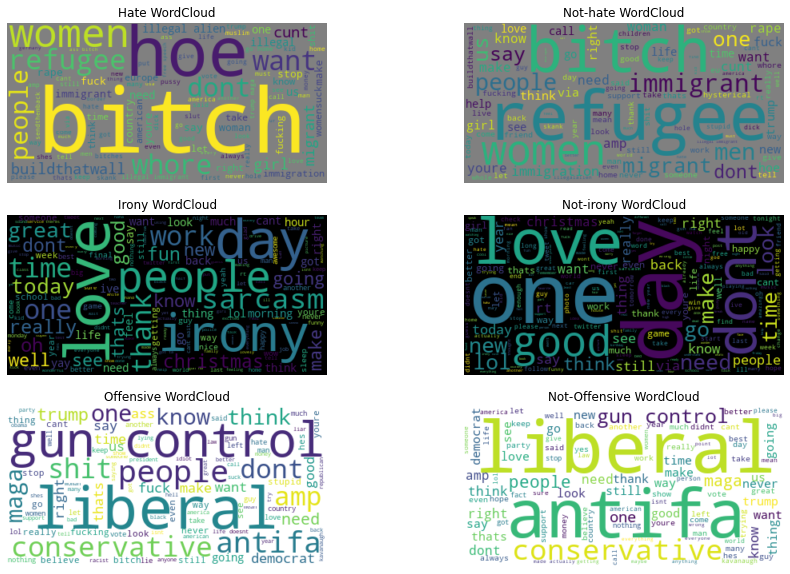

In [10]:
%store
wordcloud_not_hate = WordCloud(max_words=100,background_color="grey").generate(not_hate_text)
wordcloud_hate = WordCloud(max_words=100,background_color="grey").generate(hate_text)

wordcloud_not_irony = WordCloud().generate(not_irony_text)
wordcloud_irony = WordCloud().generate(irony_text)

wordcloud_not_offensive = WordCloud(max_words=100,background_color="white").generate(not_offensive_text)
wordcloud_offensive = WordCloud(max_words=100,background_color="white").generate(offensive_text)

fig, axs = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0,0].axis('off')
axs[0,0].set_title("Hate WordCloud")
axs[0,0].imshow(wordcloud_hate, interpolation='bilinear')
axs[0,1].set_title("Not-hate WordCloud")
axs[0,1].imshow(wordcloud_not_hate, interpolation='bilinear')
axs[0,1].axis('off')
axs[1,0].set_title("Irony WordCloud")
axs[1,0].imshow(wordcloud_irony, interpolation='bilinear')
axs[1,0].axis('off')
axs[1,1].set_title("Not-irony WordCloud")
axs[1,1].imshow(wordcloud_not_irony, interpolation='bilinear')
axs[1,1].axis('off')
axs[2,0].set_title("Offensive WordCloud")
axs[2,0].imshow(wordcloud_offensive, interpolation='bilinear')
axs[2,0].axis('off')
axs[2,1].set_title("Not-Offensive WordCloud")
axs[2,1].imshow(wordcloud_not_offensive, interpolation='bilinear')
axs[2,1].axis('off')

plt.show()
plt.close()

In [11]:
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts:
      text = tokenizer.tokenize(text)
          
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      

      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [12]:
#Create Bert Model
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 21 s, sys: 4.15 s, total: 25.1 s
Wall time: 31.5 s


In [14]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_hate.text, df_hate.label, test_size=0.2, random_state=50)

In [16]:
train_input = bert_encode(X_train, tokenizer, max_len=160)
test_input = bert_encode(X_test, tokenizer, max_len=160)

In [17]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [18]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
train_history = model.fit(
    train_input, y_train,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/3
839/839 [==============================] - 1460s 2s/step - loss: 0.5492 - accuracy: 0.7119 - val_loss: 0.4270 - val_accuracy: 0.8001
Epoch 2/3
839/839 [==============================] - 1439s 2s/step - loss: 0.2888 - accuracy: 0.8803 - val_loss: 0.3340 - val_accuracy: 0.8632
Epoch 3/3
839/839 [==============================] - 1435s 2s/step - loss: 0.0726 - accuracy: 0.9786 - val_loss: 0.4232 - val_accuracy: 0.8829


In [24]:
train_history.history

{'accuracy': [0.752980649471283, 0.8872578144073486, 0.9741430878639221],
 'loss': [0.4961036741733551, 0.2721312642097473, 0.07914645969867706],
 'val_accuracy': [0.8000596165657043, 0.8632300496101379, 0.8828963041305542],
 'val_loss': [0.4270293116569519, 0.3340231478214264, 0.4231626093387604]}

In [25]:
model.load_weights('model.h5')
model.evaluate(test_input, y_test,batch_size=200)

21/21 [==============================] - 147s 7s/step - loss: 0.3245 - accuracy: 0.8691


[0.324456125497818, 0.8690987229347229]